In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import datetime
import pytz
import numpy as np
from matplotlib.patches import Rectangle
from IPython.display import display

orange = [24,25,27,28]

bookings = pd.read_json("../../chatbot_data/bookings/bookings3-11-23.json")

bookings = pd.DataFrame(bookings.fields.values.tolist())

# switch to a faster method of parsing datetime strings by inferring the format
bookings['start'] = pd.to_datetime(bookings['start'],infer_datetime_format=True).dt.floor('S')
bookings['created_at'] = pd.to_datetime(bookings['created_at'],infer_datetime_format=True).dt.floor('S')
bookings['modified_at'] = pd.to_datetime(bookings['modified_at'],infer_datetime_format=True).dt.floor('S')

coordinationStartDate = datetime.datetime(2023,10,12,0,0,0,0,tzinfo=pytz.timezone('UTC'))
validBookings = bookings.loc[bookings['start']>= coordinationStartDate] 

orgBookings = validBookings.loc[validBookings['user'].isin(orange)].copy()
orgBookings

,start,duration_seconds,type,description,flexibility,consumption,sensor,measurement,user,modified_at,created_at
89,2023-10-12 11:00:00+00:00,1800,housework,None,yes,0.077454,34,electricity_consumption,25,2023-10-12 10:11:23+00:00,2023-10-12 10:11:23+00:00
90,2023-10-12 11:00:00+00:00,3600,lunch,None,yes,0.074525,34,electricity_consumption,25,2023-10-12 10:13:01+00:00,2023-10-12 10:13:01+00:00
91,2023-10-12 12:00:00+00:00,2700,showering,None,yes,0.149816,34,electricity_consumption,25,2023-10-12 10:15:06+00:00,2023-10-12 10:15:06+00:00
92,2023-10-12 11:00:00+00:00,1800,hob,None,yes,0.232136,28,electricity_consumption,24,2023-10-12 10:59:30+00:00,2023-10-12 10:59:30+00:00
93,2023-10-12 14:00:00+00:00,1800,laundry,None,yes,0.014146,35,electricity_consumption,28,2023-10-12 13:46:01+00:00,2023-10-12 13:46:01+00:00
...,...,...,...,...,...,...,...,...,...,...,...
213,2023-11-01 12:00:00+00:00,1800,hob,,yes,0.230000,28,electricity_consumption,24,2023-11-01 09:04:49+00:00,2023-11-01 09:04:49+00:00
214,2023-11-01 10:00:00+00:00,3600,computer,,yes,0.100000,28,electricity_consumption,24,2023-11-01 09:05:28+00:00,2023-11-01 09:05:28+00:00
215,2023-11-01 10:00:00+00:00,3600,computer,,yes,0.100000,28,electricity_consumption,24,2023-11-01 09:05:57+00:00,2023-11-01 09:05:57+00:00
216,2023-11-01 11:00:00+00:00,3600,computer,,yes,0.100000,28,electricity_consumption,24,2023-11-01 09:06:34+00:00,2023-11-01 09:06:34+00:00


86 bookings were made by group orange.
1 of those bookings were modified.


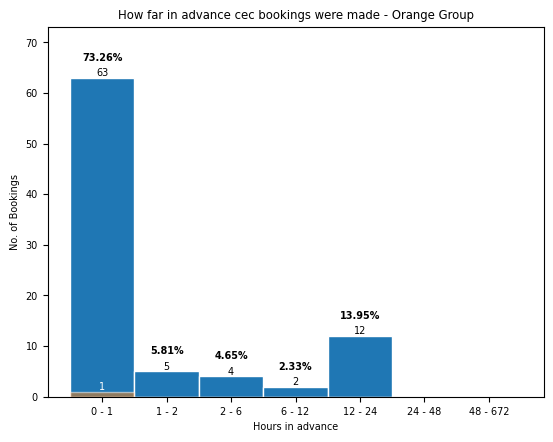

In [4]:
# Orange Group Analysis

# How far in advance was a booking made in hours?
orgBookings['diff'] = (orgBookings['start'] - orgBookings['created_at']) /pd.Timedelta(1, "h")

plt.rcParams.update({'font.size': 7})

# bins=[<1h,<2h,<6h,<12h,<24h,<48h,>48h-4w]
bins=[0,1,2,6,12,24,48,48*14]

# make bookings histogram
hist, bin_edges = np.histogram(orgBookings['diff'],bins)

# make modified bookings histogram
modified_bookings = orgBookings['diff'].where(orgBookings['modified_at'] > orgBookings['created_at'])
nested_hist, nested_bin_edges = np.histogram(modified_bookings, bins)

fig,ax = plt.subplots()

# Plot the histogram heights against integers on the x axis
outer_bars = ax.bar(range(len(hist)), hist, width=1, edgecolor="White") 

# Plot the nested histogram heights as translucent bars
nested_bars = ax.bar(range(len(nested_hist)), nested_hist, width=1, edgecolor="White", alpha=0.5)

# Set the ticks to the middle of the bars
ax.set_xticks([i for i, j in enumerate(hist)])

# Set the xticklabels to a string that tells us what the bin edges were
ax.set_xticklabels(['{} - {}'.format(bins[i], bins[i+1]) for i, j in enumerate(hist)])

ax.set_xlabel("Hours in advance")
ax.set_ylabel("No. of Bookings")

# Add the title to the histogram
ax.set_title("How far in advance cec bookings were made - Orange Group")

# # Create legend with hex colors
# handles = [Rectangle((0, 0), 1, 1, color="#1b62a5", ec="k"),
#            Rectangle((0, 0), 1, 1, color="#bf955e", ec="k")]

# labels = ["All Bookings", "Modified Bookings"]
# plt.legend(handles, labels)

# Calculate the total number of bookings for percentage calculation
total_bookings = len(orgBookings)
print(total_bookings, 'bookings were made by group orange.')
print(modified_bookings.dropna().count(), 'of those bookings were modified.')

# Add the y-axis value at the top of each bin - all pilot group bookings
for i, bar in enumerate(outer_bars):
    height = bar.get_height() #this is the value each bin corresponds to
    
    # Add the y-axis value at the top of each bin
    if height != 0:
        ax.text(bar.get_x() + bar.get_width() / 2, height, str(int(height)), ha='center', va='bottom')
    
    # Calculate and display the percentage
    percentage = (height / total_bookings) * 100
    if percentage != 0:
        ax.text(bar.get_x() + bar.get_width() / 2, height + 3, f"{percentage:.2f}%", ha='center', va='bottom', fontweight='bold')

    
# Add the y-axis value at the top of each bin - modified bookings in pilot group
for i, bar in enumerate(nested_bars):
    height = bar.get_height() #this is the value each bin corresponds to
            
    # Add the y-axis value at the top of each bin
    if height != 0:
        ax.text(bar.get_x() + bar.get_width() / 2, height, str(int(height)), ha='center', va='bottom', color='w')
    
# Extend the y-axis by setting the minimum and maximum limits
min_y = 0
max_y = max(hist) + 10  # Add some extra space above the highest bar
ax.set_ylim(min_y, max_y)

plt.savefig('group_orange_cec_booking_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

In [5]:
# User 27 -  Camilla

bookingsUser27 = orgBookings.loc[orgBookings['user'] == 27].copy()

bookingsUser27

,start,duration_seconds,type,description,flexibility,consumption,sensor,measurement,user,modified_at,created_at,diff
95,2023-10-13 08:00:00+00:00,1800,laundry,None,yes,0.172940,17,electricity_consumption,27,2023-10-12 18:20:06+00:00,2023-10-12 18:20:06+00:00,13.665000
97,2023-10-13 07:00:00+00:00,1800,dishwasher,None,yes,0.220771,17,electricity_consumption,27,2023-10-12 18:33:36+00:00,2023-10-12 18:33:36+00:00,12.440000
106,2023-10-15 08:00:00+00:00,1800,dishwasher,None,yes,0.220771,17,electricity_consumption,27,2023-10-14 08:18:43+00:00,2023-10-14 08:18:43+00:00,23.688056
109,2023-10-16 18:00:00+00:00,3600,laundry,None,yes,0.345881,17,electricity_consumption,27,2023-10-16 07:42:09+00:00,2023-10-16 07:42:09+00:00,10.297500
110,2023-10-16 08:00:00+00:00,1800,dishwasher,None,yes,0.220771,17,electricity_consumption,27,2023-10-16 07:42:32+00:00,2023-10-16 07:42:32+00:00,0.291111
111,2023-10-16 17:00:00+00:00,1800,hob,None,yes,0.145263,17,electricity_consumption,27,2023-10-16 07:42:56+00:00,2023-10-16 07:42:56+00:00,9.284444
135,2023-10-21 09:00:00+00:00,3600,dishwasher,None,yes,0.441542,17,electricity_consumption,27,2023-10-20 18:15:53+00:00,2023-10-20 18:15:53+00:00,14.735278
136,2023-10-21 08:00:00+00:00,3600,laundry,None,yes,0.345881,17,electricity_consumption,27,2023-10-20 18:16:29+00:00,2023-10-20 18:16:29+00:00,13.725278
137,2023-10-21 10:00:00+00:00,3600,housework,None,yes,0.353253,17,electricity_consumption,27,2023-10-20 18:16:58+00:00,2023-10-20 18:16:58+00:00,15.717222
164,2023-10-26 11:00:00+00:00,3600,laundry,None,yes,0.345881,17,electricity_consumption,27,2023-10-25 19:10:30+00:00,2023-10-25 19:10:30+00:00,15.825000


15 bookings were made by User 27 - Camilla.
0 of those bookings were modified.


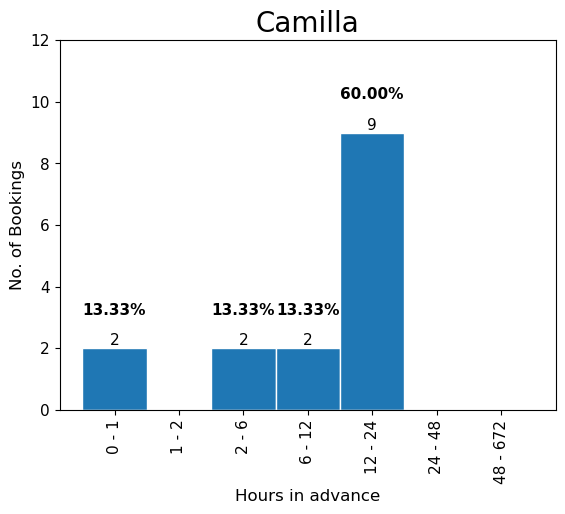

In [9]:
# Booking pattern for User 27

# How far in advance was a booking made in hours?
bookingsUser27['diff'] = (bookingsUser27['start'] - bookingsUser27['created_at']) /pd.Timedelta(1, "h")

plt.rcParams.update({'font.size': 11})

# bins=[<1h,<2h,<6h,<12h,<24h,<48h,>48h-4w]
bins=[0,1,2,6,12,24,48,48*14]

# make bookings histogram
hist, bin_edges = np.histogram(bookingsUser27['diff'],bins)

# make modified bookings histogram
modified_bookings_user_27 = bookingsUser27['diff'].where(bookingsUser27['modified_at'] > bookingsUser27['created_at'])
nested_hist, nested_bin_edges = np.histogram(modified_bookings_user_27, bins)

fig,ax = plt.subplots()

# Plot the histogram heights against integers on the x axis
outer_bars = ax.bar(range(len(hist)), hist, width=1, edgecolor="White") 

# Plot the nested histogram heights as translucent bars
nested_bars = ax.bar(range(len(nested_hist)), nested_hist, width=1, edgecolor="White", alpha=0.5)

# Set the ticks to the middle of the bars
ax.set_xticks([i for i, j in enumerate(hist)])

# Set the xticklabels to a string that tells us what the bin edges were
ax.set_xticklabels(['{} - {}'.format(bins[i], bins[i+1]) for i, j in enumerate(hist)], rotation = 90)

ax.set_xlabel("Hours in advance", fontsize = 12)
ax.set_ylabel("No. of Bookings", fontsize = 12)

# Add the title to the histogram
ax.set_title("Camilla", fontsize = 20)

# # Create legend with hex colors
# handles = [Rectangle((0, 0), 1, 1, color="#1b62a5", ec="k"),
#            Rectangle((0, 0), 1, 1, color="#bf955e", ec="k")]

# labels = ["All Bookings", "Modified Bookings"]
# plt.legend(handles, labels)

# Calculate the total number of bookings for percentage calculation
total_bookings = len(bookingsUser27)
print(total_bookings, 'bookings were made by User 27 - Camilla.')
print(modified_bookings_user_27.dropna().count(), 'of those bookings were modified.')

# Add the y-axis value at the top of each bin - all user 27 bookings
for i, bar in enumerate(outer_bars):
    height = bar.get_height() #this is the value each bin corresponds to
            
    # Add the y-axis value at the top of each bin
    if height != 0:
        ax.text(bar.get_x() + bar.get_width() / 2, height, str(int(height)), ha='center', va='bottom')
    
    # Calculate and display the percentage
    percentage = (height / total_bookings) * 100
    
    if percentage != 0:
        ax.text(bar.get_x() + bar.get_width() / 2, height + 1, f"{percentage:.2f}%", ha='center', va='bottom', fontweight='bold')

    
# Add the y-axis value at the top of each bin - modified bookings in user 27
for i, bar in enumerate(nested_bars):
    height = bar.get_height() # this is the value each bin corresponds to
            
    # Add the y-axis value at the top of each bin
    if height != 0:
        ax.text(bar.get_x() + bar.get_width() / 2, height, str(int(height)), ha='center', va='bottom', color='w')
    
# Extend the y-axis by setting the minimum and maximum limits
min_y = 0
max_y = 12  # Add some extra space above the highest bar
ax.set_ylim(min_y, max_y)

plt.savefig('camilla_booking_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
# User 28 - Laura

bookingsUser28 = orgBookings.loc[orgBookings['user'] == 28].copy()

bookingsUser28

,start,duration_seconds,type,description,flexibility,consumption,sensor,measurement,user,modified_at,created_at,diff
93,2023-10-12 14:00:00+00:00,1800,laundry,None,yes,0.014146,35,electricity_consumption,28,2023-10-12 13:46:01+00:00,2023-10-12 13:46:01+00:00,0.233056
94,2023-10-12 18:00:00+00:00,300,hob,None,yes,0.001365,35,electricity_consumption,28,2023-10-12 17:58:41+00:00,2023-10-12 17:58:41+00:00,0.021944
96,2023-10-12 19:00:00+00:00,600,hob,None,yes,0.002730,35,electricity_consumption,28,2023-10-12 18:27:19+00:00,2023-10-12 18:27:19+00:00,0.544722
98,2023-10-12 19:00:00+00:00,900,hob,None,yes,0.004095,35,electricity_consumption,28,2023-10-12 18:49:25+00:00,2023-10-12 18:49:25+00:00,0.176389
99,2023-10-12 20:00:00+00:00,2940,hob,None,yes,0.013376,35,electricity_consumption,28,2023-10-12 19:28:23+00:00,2023-10-12 19:28:23+00:00,0.526944
112,2023-10-16 20:00:00+00:00,1800,laundry,None,yes,0.014146,35,electricity_consumption,28,2023-10-16 19:34:05+00:00,2023-10-16 19:34:05+00:00,0.431944
115,2023-10-17 13:00:00+00:00,3600,laundry,None,yes,0.028292,35,electricity_consumption,28,2023-10-17 12:52:55+00:00,2023-10-17 12:52:06+00:00,0.131667
116,2023-10-17 18:00:00+00:00,1800,oven,None,yes,0.013981,35,electricity_consumption,28,2023-10-17 17:26:19+00:00,2023-10-17 17:26:19+00:00,0.561389
117,2023-10-17 18:00:00+00:00,1800,hob,None,yes,0.008190,35,electricity_consumption,28,2023-10-17 17:27:20+00:00,2023-10-17 17:27:20+00:00,0.544444
118,2023-10-17 22:00:00+00:00,1800,laundry,None,yes,0.014146,35,electricity_consumption,28,2023-10-17 21:14:29+00:00,2023-10-17 21:14:29+00:00,0.758611


39 bookings were made by User 28 - Laura.
1 of those bookings were modified.


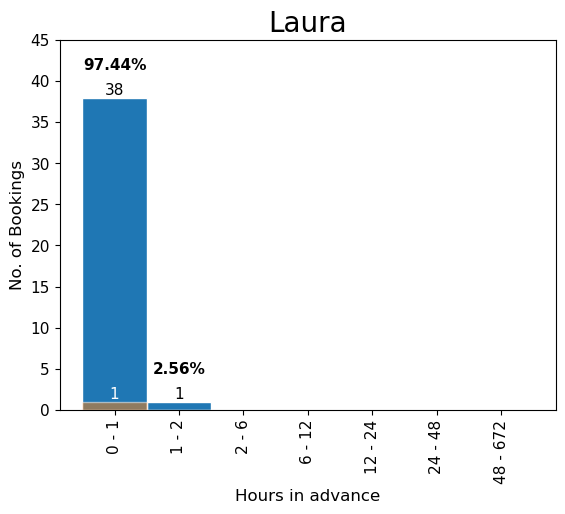

In [14]:
# Booking pattern for User 28

# How far in advance was a booking made in hours?
bookingsUser28['diff'] = (bookingsUser28['start'] - bookingsUser28['created_at']) /pd.Timedelta(1, "h")

plt.rcParams.update({'font.size': 11})

# bins=[<1h,<2h,<6h,<12h,<24h,<48h,>48h-4w]
bins=[0,1,2,6,12,24,48,48*14]

# make bookings histogram
hist, bin_edges = np.histogram(bookingsUser28['diff'],bins)

# make modified bookings histogram
modified_bookings_user_28 = bookingsUser28['diff'].where(bookingsUser28['modified_at'] > bookingsUser28['created_at'])
nested_hist, nested_bin_edges = np.histogram(modified_bookings_user_28, bins)

fig,ax = plt.subplots()

# Plot the histogram heights against integers on the x axis
outer_bars = ax.bar(range(len(hist)), hist, width=1, edgecolor="White") 

# Plot the nested histogram heights as translucent bars
nested_bars = ax.bar(range(len(nested_hist)), nested_hist, width=1, edgecolor="White", alpha=0.5)

# Set the ticks to the middle of the bars
ax.set_xticks([i for i, j in enumerate(hist)])

# Set the xticklabels to a string that tells us what the bin edges were
ax.set_xticklabels(['{} - {}'.format(bins[i], bins[i+1]) for i, j in enumerate(hist)], rotation = 90)

ax.set_xlabel("Hours in advance", fontsize = 12)
ax.set_ylabel("No. of Bookings", fontsize = 12)

# Add the title to the histogram
ax.set_title("Laura", fontsize = 20)

# # Create legend with hex colors
# handles = [Rectangle((0, 0), 1, 1, color="#1b62a5", ec="k"),
#            Rectangle((0, 0), 1, 1, color="#bf955e", ec="k")]

# labels = ["All Bookings", "Modified Bookings"]
# plt.legend(handles, labels)

# Calculate the total number of bookings for percentage calculation
total_bookings = len(bookingsUser28)
print(total_bookings, 'bookings were made by User 28 - Laura.')
print(modified_bookings_user_28.dropna().count(), 'of those bookings were modified.')

# Add the y-axis value at the top of each bin - all user 28 bookings
for i, bar in enumerate(outer_bars):
    height = bar.get_height() #this is the value each bin corresponds to
            
    # Add the y-axis value at the top of each bin
    if height != 0:
        ax.text(bar.get_x() + bar.get_width() / 2, height, str(int(height)), ha='center', va='bottom')
    
    # Calculate and display the percentage
    percentage = (height / total_bookings) * 100
    
    if percentage != 0:
        ax.text(bar.get_x() + bar.get_width() / 2, height + 3, f"{percentage:.2f}%", ha='center', va='bottom', fontweight='bold')

    
# Add the y-axis value at the top of each bin - modified bookings in user 28
for i, bar in enumerate(nested_bars):
    height = bar.get_height() # this is the value each bin corresponds to
            
    # Add the y-axis value at the top of each bin
    if height != 0:
        ax.text(bar.get_x() + bar.get_width() / 2, height, str(int(height)), ha='center', va='bottom', color='w')
    
# Extend the y-axis by setting the minimum and maximum limits
min_y = 0
max_y = 45  # Add some extra space above the highest bar
ax.set_ylim(min_y, max_y)

plt.savefig('laura_booking_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# User 25 - Hayley

bookingsUser25 = orgBookings.loc[orgBookings['user'] == 25].copy()

bookingsUser25

,start,duration_seconds,type,description,flexibility,consumption,sensor,measurement,user,modified_at,created_at,diff
89,2023-10-12 11:00:00+00:00,1800,housework,None,yes,0.077454,34,electricity_consumption,25,2023-10-12 10:11:23+00:00,2023-10-12 10:11:23+00:00,0.810278
90,2023-10-12 11:00:00+00:00,3600,lunch,None,yes,0.074525,34,electricity_consumption,25,2023-10-12 10:13:01+00:00,2023-10-12 10:13:01+00:00,0.783056
91,2023-10-12 12:00:00+00:00,2700,showering,None,yes,0.149816,34,electricity_consumption,25,2023-10-12 10:15:06+00:00,2023-10-12 10:15:06+00:00,1.748333
100,2023-10-13 11:00:00+00:00,1800,oven,None,yes,0.028600,34,electricity_consumption,25,2023-10-13 10:38:00+00:00,2023-10-13 10:38:00+00:00,0.366667
102,2023-10-13 17:00:00+00:00,1800,housework,None,yes,0.077454,34,electricity_consumption,25,2023-10-13 16:17:53+00:00,2023-10-13 16:17:53+00:00,0.701944
103,2023-10-13 18:00:00+00:00,1800,microwave,None,yes,0.014480,34,electricity_consumption,25,2023-10-13 17:08:16+00:00,2023-10-13 17:08:16+00:00,0.862222
107,2023-10-15 09:00:00+00:00,1800,showering,None,yes,0.099877,34,electricity_consumption,25,2023-10-15 08:46:54+00:00,2023-10-15 08:46:54+00:00,0.218333
114,2023-10-17 12:00:00+00:00,12000,laundry,None,yes,0.368244,34,electricity_consumption,25,2023-10-17 09:13:45+00:00,2023-10-17 09:13:45+00:00,2.770833
128,2023-10-20 09:00:00+00:00,7200,laundry,None,yes,0.220946,34,electricity_consumption,25,2023-10-20 08:23:32+00:00,2023-10-20 08:23:32+00:00,0.607778
133,2023-10-20 15:00:00+00:00,2700,lunch,None,yes,0.055894,34,electricity_consumption,25,2023-10-20 14:53:55+00:00,2023-10-20 14:53:55+00:00,0.101389


14 bookings were made by User 25 - Hayley.
0 of those bookings were modified.


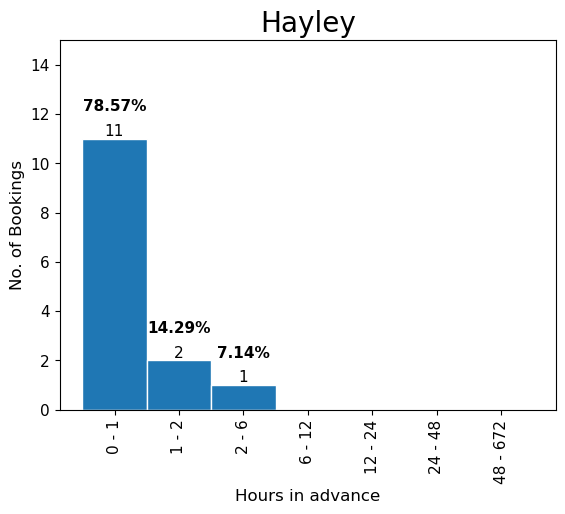

In [18]:
# Booking pattern for User 25 - Hayley

# How far in advance was a booking made in hours?
bookingsUser25['diff'] = (bookingsUser25['start'] - bookingsUser25['created_at']) /pd.Timedelta(1, "h")

plt.rcParams.update({'font.size': 11})

# bins=[<1h,<2h,<6h,<12h,<24h,<48h,>48h-4w]
bins=[0,1,2,6,12,24,48,48*14]

# make bookings histogram
hist, bin_edges = np.histogram(bookingsUser25['diff'],bins)

# make modified bookings histogram
modified_bookings_user_25 = bookingsUser25['diff'].where(bookingsUser25['modified_at'] > bookingsUser25['created_at'])
nested_hist, nested_bin_edges = np.histogram(modified_bookings_user_25, bins)

fig,ax = plt.subplots()

# Plot the histogram heights against integers on the x axis
outer_bars = ax.bar(range(len(hist)), hist, width=1, edgecolor="White") 

# Plot the nested histogram heights as translucent bars
nested_bars = ax.bar(range(len(nested_hist)), nested_hist, width=1, edgecolor="White", alpha=0.5)

# Set the ticks to the middle of the bars
ax.set_xticks([i for i, j in enumerate(hist)])

# Set the xticklabels to a string that tells us what the bin edges were
ax.set_xticklabels(['{} - {}'.format(bins[i], bins[i+1]) for i, j in enumerate(hist)], rotation = 90)

ax.set_xlabel("Hours in advance", fontsize = 12)
ax.set_ylabel("No. of Bookings", fontsize = 12)

# Add the title to the histogram
ax.set_title("Hayley", fontsize = 20)

# # Create legend with hex colors
# handles = [Rectangle((0, 0), 1, 1, color="#1b62a5", ec="k"),
#            Rectangle((0, 0), 1, 1, color="#bf955e", ec="k")]

# labels = ["All Bookings", "Modified Bookings"]
# plt.legend(handles, labels)

# Calculate the total number of bookings for percentage calculation
total_bookings = len(bookingsUser25)
print(total_bookings, 'bookings were made by User 25 - Hayley.')
print(modified_bookings_user_25.dropna().count(), 'of those bookings were modified.')

# Add the y-axis value at the top of each bin - all user 25 bookings
for i, bar in enumerate(outer_bars):
    height = bar.get_height() #this is the value each bin corresponds to
            
    # Add the y-axis value at the top of each bin
    if height != 0:
        ax.text(bar.get_x() + bar.get_width() / 2, height, str(int(height)), ha='center', va='bottom')
    
    # Calculate and display the percentage
    percentage = (height / total_bookings) * 100
    
    if percentage != 0:
        ax.text(bar.get_x() + bar.get_width() / 2, height + 1, f"{percentage:.2f}%", ha='center', va='bottom', fontweight='bold')

    
# Add the y-axis value at the top of each bin - modified bookings in user 25
for i, bar in enumerate(nested_bars):
    height = bar.get_height() # this is the value each bin corresponds to
            
    # Add the y-axis value at the top of each bin
    if height != 0:
        ax.text(bar.get_x() + bar.get_width() / 2, height, str(int(height)), ha='center', va='bottom', color='w')
    
# Extend the y-axis by setting the minimum and maximum limits
min_y = 0
max_y = 15  # Add some extra space above the highest bar
ax.set_ylim(min_y, max_y)

plt.savefig('hayley_booking_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
# User 24 - Tony

bookingsUser24 = orgBookings.loc[orgBookings['user'] == 24].copy()

bookingsUser24

,start,duration_seconds,type,description,flexibility,consumption,sensor,measurement,user,modified_at,created_at,diff
92,2023-10-12 11:00:00+00:00,1800,hob,None,yes,0.232136,28,electricity_consumption,24,2023-10-12 10:59:30+00:00,2023-10-12 10:59:30+00:00,0.008333
101,2023-10-13 12:00:00+00:00,1800,hob,None,yes,0.232136,28,electricity_consumption,24,2023-10-13 11:49:41+00:00,2023-10-13 11:49:41+00:00,0.171944
104,2023-10-14 07:00:00+00:00,5400,laundry,None,yes,0.585461,28,electricity_consumption,24,2023-10-13 18:24:38+00:00,2023-10-13 18:24:38+00:00,12.589444
105,2023-10-14 07:00:00+00:00,14400,computer,None,yes,0.396993,28,electricity_consumption,24,2023-10-13 18:26:08+00:00,2023-10-13 18:26:08+00:00,12.564444
108,2023-10-15 13:00:00+00:00,5400,laundry,None,yes,0.585461,28,electricity_consumption,24,2023-10-15 12:16:29+00:00,2023-10-15 12:16:29+00:00,0.725278
113,2023-10-17 09:00:00+00:00,7200,computer,None,yes,0.198496,28,electricity_consumption,24,2023-10-17 08:16:00+00:00,2023-10-17 08:16:00+00:00,0.733333
119,2023-10-18 11:00:00+00:00,3600,hob,None,yes,0.464272,28,electricity_consumption,24,2023-10-18 09:41:15+00:00,2023-10-18 09:41:15+00:00,1.312500
130,2023-10-20 11:00:00+00:00,1800,hob,None,yes,0.232136,28,electricity_consumption,24,2023-10-20 10:16:43+00:00,2023-10-20 10:16:43+00:00,0.721389
141,2023-10-21 11:00:00+00:00,1800,hob,None,yes,0.232136,28,electricity_consumption,24,2023-10-21 11:00:00+00:00,2023-10-21 11:00:00+00:00,0.000000
153,2023-10-23 09:00:00+00:00,5400,laundry,None,yes,0.585461,28,electricity_consumption,24,2023-10-23 08:17:27+00:00,2023-10-23 08:17:27+00:00,0.709167


18 bookings were made by User 24 - Tony.
0 of those bookings were modified.


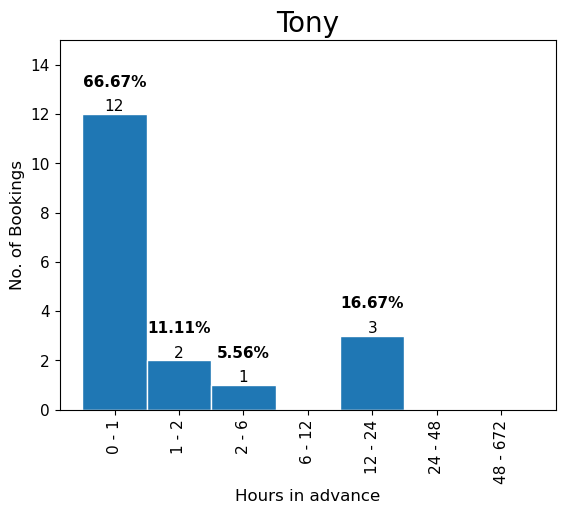

In [21]:
# Booking pattern for User 24 - Tony

# How far in advance was a booking made in hours?
bookingsUser24['diff'] = (bookingsUser24['start'] - bookingsUser24['created_at']) /pd.Timedelta(1, "h")

plt.rcParams.update({'font.size': 11})

# bins=[<1h,<2h,<6h,<12h,<24h,<48h,>48h-4w]
bins=[0,1,2,6,12,24,48,48*14]

# make bookings histogram
hist, bin_edges = np.histogram(bookingsUser24['diff'],bins)

# make modified bookings histogram
modified_bookings_user_24 = bookingsUser24['diff'].where(bookingsUser24['modified_at'] > bookingsUser24['created_at'])
nested_hist, nested_bin_edges = np.histogram(modified_bookings_user_24, bins)

fig,ax = plt.subplots()

# Plot the histogram heights against integers on the x axis
outer_bars = ax.bar(range(len(hist)), hist, width=1, edgecolor="White") 

# Plot the nested histogram heights as translucent bars
nested_bars = ax.bar(range(len(nested_hist)), nested_hist, width=1, edgecolor="White", alpha=0.5)

# Set the ticks to the middle of the bars
ax.set_xticks([i for i, j in enumerate(hist)])

# Set the xticklabels to a string that tells us what the bin edges were
ax.set_xticklabels(['{} - {}'.format(bins[i], bins[i+1]) for i, j in enumerate(hist)], rotation = 90)

ax.set_xlabel("Hours in advance", fontsize = 12)
ax.set_ylabel("No. of Bookings", fontsize = 12)

# Add the title to the histogram
ax.set_title("Tony", fontsize = 20)

# # Create legend with hex colors
# handles = [Rectangle((0, 0), 1, 1, color="#1b62a5", ec="k"),
#            Rectangle((0, 0), 1, 1, color="#bf955e", ec="k")]

# labels = ["All Bookings", "Modified Bookings"]
# plt.legend(handles, labels)

# Calculate the total number of bookings for percentage calculation
total_bookings = len(bookingsUser24)
print(total_bookings, 'bookings were made by User 24 - Tony.')
print(modified_bookings_user_24.dropna().count(), 'of those bookings were modified.')

# Add the y-axis value at the top of each bin - all user 24 bookings
for i, bar in enumerate(outer_bars):
    height = bar.get_height() #this is the value each bin corresponds to
            
    # Add the y-axis value at the top of each bin
    if height != 0:
        ax.text(bar.get_x() + bar.get_width() / 2, height, str(int(height)), ha='center', va='bottom')
    
    # Calculate and display the percentage
    percentage = (height / total_bookings) * 100
    
    if percentage != 0:
        ax.text(bar.get_x() + bar.get_width() / 2, height + 1, f"{percentage:.2f}%", ha='center', va='bottom', fontweight='bold')

    
# Add the y-axis value at the top of each bin - modified bookings in user 24
for i, bar in enumerate(nested_bars):
    height = bar.get_height() # this is the value each bin corresponds to
            
    # Add the y-axis value at the top of each bin
    if height != 0:
        ax.text(bar.get_x() + bar.get_width() / 2, height, str(int(height)), ha='center', va='bottom', color='w')
    
# Extend the y-axis by setting the minimum and maximum limits
min_y = 0
max_y = 15  # Add some extra space above the highest bar
ax.set_ylim(min_y, max_y)

plt.savefig('tony_booking_histogram.png', dpi=300, bbox_inches='tight')
plt.show()